# ゼロから作る遺伝的アルゴリズム

## 概要
### 目標
+ ライブラリに頼らずゼロから作ることでアルゴリズムの中身を理解する
+ リアルタイムに更新状況を確認することでどういう風に進化しているかを見る
    
### 今回最適化する問題

+ **2変数関数の最大値を求める**

### 遺伝的アルゴリズムの基礎的な流れ

1. 第1世代の個体群の生成
2. 適応度の高い個体を選択(一番関数の最大値が高いものを選択)
3. エリート個体との交差や突然変異で次の世代の個体群を生成
4. 2と3を繰り返すことで、最後に最も適応度の高い個体を解として出力

### 参考サイト
> https://qiita.com/peperoncino000/items/0f527a72270430017d8d

## 使用ライブラリのインポート

In [21]:
import random
import numpy as np
random.seed(98) # 再現性の担保

## 1.個体群の生成

In [15]:
## テスト関数と仮初期値設定
x, y = 1e-7, 1e-7

## 変数設定
gene_length = 2 # 遺伝子の長さ。今回は2変数なので2
individual_length = 10 # 個体数
generation = 50 # 世代数
mutate_rate = 0.1 # 突然変異の割合
elite_rate = 0.2 # 残すエリートの割合

In [8]:
population = []
for i in range(individual_length):
    population.append([random.random() for j in range(gene_length)])

In [10]:
# x,y の座標の入った個体が10個生成される
print(population)

[[0.35639820676272216, 0.8311602774491931], [0.35237864716479084, 0.0587248129543273], [0.4733305296443464, 0.7281813831416379], [0.6784899127202754, 0.06465340992924462], [0.49701684646407485, 0.19592491833566006], [0.03453679871361848, 0.9796207979853099], [0.7048751023416616, 0.36096984151020983], [0.7759995593130692, 0.7911525137028831], [0.007468944436742619, 0.3833047283684954], [0.30461586515781447, 0.046179053500550626]]


## 2. 適応度と評価、交叉と突然変異の実装

今回の適応度については関数の最大値としているため最大値が最も高いものを適応していると判断しています。

### 適応度と評価の実装

In [20]:
def fitness(x,y):
    return 1 / x**2 * 5  + y**2 * 5 + 0.7  

def evaluate(pop):
    pop.sort(reverse=True)
    return pop

### 交叉と突然変異の実装
今回は2変数であるため、以下の2種の交叉方法を実装する。

+ BLX-α
    + 両親の遺伝子が表す実数値ベクトルの区間を両方向にαだけ拡張した区間から、一様乱数に従ってランダムに子を生成する手法
    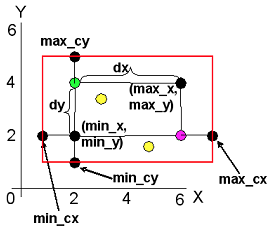
    > http://www.sist.ac.jp/~kanakubo/research/evolutionary_computing/lbx_spx.html
+ UNDX
    + 2個体の親を結ぶ直線の周辺に正規分布に従って子を生成する手法。この時3番目の親を正規分布の標準偏差を決めるために用いる。

In [25]:
alpha=0.3
def blx_alpha_crossover(parent1, parent2, alpha):
    # 親個体の距離
    dx = abs(parent1[0] - parent2[0])
    dy = abs(parent1[1] - parent2[1])
    # 親個体の座標の最小値
    min_x = min(parent1[0], parent2[0])
    min_y = min(parent1[1], parent2[1])
    # 親子体の座標の最大値
    max_x = max(parent1[0], parent2[0])
    max_y = max(parent1[1], parent2[1])
    
    # 次の世代の座標をalpha分だけずらす
    min_cx = min_x - alpha * dx
    max_cx = max_x + alpha * dx
    min_cy = min_y - alpha * dy
    max_cy = max_y + alpha * dy
    
    # 一様乱数に従って範囲内から座標を決定する
    return ((max_cx - min_cx) * np.random.rand() + min_cx, \
           (max_cy - min_cy) * np.random.rand() + min_cy)